In [1]:
# Cell 1: Import necessary libraries
! pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import json
import os
from pathlib import Path

# Visualization settings
#plt.style.use('seaborn-v0_8-whitegrid')
#plt.rcParams['figure.figsize'] = (12, 6)
#sns.set_palette("viridis")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from datetime import datetime

# # Set visualization style
# plt.style.use('seaborn')
# sns.set_palette("husl")


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
print(os.getcwd())


/home/aishwarya/Columbia/Spring 2025/Machine Learning and Climate/ML-For-Climate-Project/src/notebooks


In [ ]:
def create_lag_features(data, target_col='AQI', n_lags=7):
    """Create lag features for the target column"""
    data = data.sort_values('Date')
    for i in range(1, n_lags + 1):
        data[f'{target_col}_lag_{i}'] = data[target_col].shift(i)
    return data

# Cell 2: Load pre-split data for each city
# processed_dir = '/mnt/d/Sidhant Coding Projects/ML-For-Climate-Project/src/data/processed'
processed_dir = '../data/processed'

cities = ['bengaluru', 'chennai', 'delhi', 'hyderabad']

# Dictionary to store data for each city
city_data = {}

for city in cities:
    city_dir = f'{processed_dir}/{city.lower()}'
    city_data[city] = {
        'train': pd.read_csv(f'{city_dir}/train.csv'),
        'val': pd.read_csv(f'{city_dir}/val.csv'),
        'test': pd.read_csv(f'{city_dir}/test.csv')
    }
    
    # Convert date columns to datetime
    for split in ['train', 'val', 'test']:
        city_data[city][split]['Date'] = pd.to_datetime(city_data[city][split]['Date'])
        
        # Check if lag features exist, if not create them
        if 'AQI_lag_1' not in city_data[city][split].columns:
            print(f"Creating lag features for {city} {split} set")
            city_data[city][split] = create_lag_features(city_data[city][split])
    
    print(f"\n{city.title()} data loaded:")
    print(f"Train: {city_data[city]['train'].shape[0]} samples")
    print(f"Validation: {city_data[city]['val'].shape[0]} samples")
    print(f"Test: {city_data[city]['test'].shape[0]} samples")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/Sidhant Coding Projects/ML-For-Climate-Project/src/data/processed/bengaluru/train.csv'

In [45]:
# 1. First, let's load the preprocessed data for each city
def load_city_data(city_name):
    """Load preprocessed data for a specific city"""
    data_dir = "../data/processed"
    city_data = {}
    
    for split in ['train', 'val', 'test']:
        file_path = f"{data_dir}/{city_name}/{split}.csv"
        # print(file_path)
        if os.path.exists(file_path):
            city_data[split] = pd.read_csv(file_path)
            city_data[split]['date'] = pd.to_datetime(city_data[split]['Date'])
    
    return city_data



In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [47]:
class CNNRegressor(nn.Module):
    def __init__(self, input_channels=1, input_length=7):
        super(CNNRegressor, self).__init__()
        
        # Improved CNN architecture
        self.features = nn.Sequential(
            # First conv block
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Second conv block
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Third conv block
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Global average pooling
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()


In [48]:
def prepare_cnn_data_torch(city_data):
    numeric_cols = city_data['train'].select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'AQI']
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(city_data['train'][numeric_cols])
    X_val = scaler.transform(city_data['val'][numeric_cols])
    X_test = scaler.transform(city_data['test'][numeric_cols])
    
    X_train = torch.tensor(X_train[:, :, np.newaxis], dtype=torch.float32).permute(0, 2, 1)
    X_val = torch.tensor(X_val[:, :, np.newaxis], dtype=torch.float32).permute(0, 2, 1)
    X_test = torch.tensor(X_test[:, :, np.newaxis], dtype=torch.float32).permute(0, 2, 1)
    
    y_train = torch.tensor(city_data['train']['AQI'].values, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(city_data['val']['AQI'].values, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(city_data['test']['AQI'].values, dtype=torch.float32).unsqueeze(1)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), len(numeric_cols)


In [49]:
def train_and_evaluate_cnn_torch(city_data, city_name, epochs=200, batch_size=32, lr=0.001):
    """Train and evaluate CNN model with improved training process"""
    print(f"\n🔄 Preprocessing data for {city_name}...")
    
    # Get numeric columns (excluding AQI)
    numeric_cols = city_data['train'].select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['AQI']]
    
    # Handle missing values in features and target
    X_train = city_data['train'][numeric_cols].fillna(method='ffill').fillna(method='bfill')
    y_train = city_data['train']['AQI'].fillna(method='ffill').fillna(method='bfill')
    
    X_val = city_data['val'][numeric_cols].fillna(method='ffill').fillna(method='bfill')
    y_val = city_data['val']['AQI'].fillna(method='ffill').fillna(method='bfill')
    
    X_test = city_data['test'][numeric_cols].fillna(method='ffill').fillna(method='bfill')
    y_test = city_data['test']['AQI'].fillna(method='ffill').fillna(method='bfill')
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Scale targets (important for neural networks)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).ravel()
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train_scaled).unsqueeze(1)
    y_train = torch.FloatTensor(y_train_scaled)
    X_val = torch.FloatTensor(X_val_scaled).unsqueeze(1)
    y_val = torch.FloatTensor(y_val_scaled)
    X_test = torch.FloatTensor(X_test_scaled).unsqueeze(1)
    y_test = torch.FloatTensor(y_test_scaled)
    
    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
    
    # Initialize model
    print("🔧 Initializing model...")
    device = torch.device('cuda')
    print("Using device: ", device)
    input_len = X_train.shape[2]
    model = CNNRegressor(input_channels=1, input_length=input_len).to(device)
    
    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Use MSE loss
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Training loop
    print("🏃 Starting training...")
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_preds.extend(outputs.cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
        
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Final evaluation
    print("📊 Evaluating model...")
    model.eval()
    
    # Get predictions
    def get_predictions(loader):
        preds = []
        true = []
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                preds.extend(outputs.cpu().numpy())
                true.extend(batch_y.numpy())
        return np.array(preds), np.array(true)
    
    val_preds, val_true = get_predictions(val_loader)
    test_preds, test_true = get_predictions(test_loader)
    
    # Inverse transform predictions and true values
    val_preds = target_scaler.inverse_transform(val_preds.reshape(-1, 1)).ravel()
    val_true = target_scaler.inverse_transform(val_true.reshape(-1, 1)).ravel()
    test_preds = target_scaler.inverse_transform(test_preds.reshape(-1, 1)).ravel()
    test_true = target_scaler.inverse_transform(test_true.reshape(-1, 1)).ravel()
    
    # Calculate metrics
    def calc_metrics(y_true, y_pred):
        return {
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred)
        }
    
    val_metrics = calc_metrics(val_true, val_preds)
    test_metrics = calc_metrics(test_true, test_preds)
    
    print(f"\n📍 Evaluation Results for {city_name} (PyTorch CNN)")
    print("\nValidation Metrics:")
    print(f"RMSE: {val_metrics['rmse']:.2f}")
    print(f"MAE: {val_metrics['mae']:.2f}")
    print(f"R²: {val_metrics['r2']:.2f}")
    
    print("\nTest Metrics:")
    print(f"RMSE: {test_metrics['rmse']:.2f}")
    print(f"MAE: {test_metrics['mae']:.2f}")
    print(f"R²: {test_metrics['r2']:.2f}")
    
    return {
        'model': model,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'predictions': {
            'val': val_preds,
            'test': test_preds
        }
    }

In [50]:
cnn_torch_results = train_and_evaluate_cnn_torch(city_data['delhi'], 'delhi')



🔄 Preprocessing data for delhi...
🔧 Initializing model...
Using device:  cuda
🏃 Starting training...
Epoch [1/200], Train Loss: 0.9033, Val Loss: 0.6476
Epoch [2/200], Train Loss: 0.7448, Val Loss: 0.4234
Epoch [3/200], Train Loss: 0.6118, Val Loss: 0.2204
Epoch [4/200], Train Loss: 0.4754, Val Loss: 0.3275
Epoch [5/200], Train Loss: 0.3842, Val Loss: 0.2140
Epoch [6/200], Train Loss: 0.3475, Val Loss: 0.3390
Epoch [7/200], Train Loss: 0.3336, Val Loss: 0.1090
Epoch [8/200], Train Loss: 0.3020, Val Loss: 0.2987
Epoch [9/200], Train Loss: 0.2814, Val Loss: 0.0974
Epoch [10/200], Train Loss: 0.2551, Val Loss: 0.0892
Epoch [11/200], Train Loss: 0.2590, Val Loss: 0.1393
Epoch [12/200], Train Loss: 0.2372, Val Loss: 0.1165
Epoch [13/200], Train Loss: 0.2421, Val Loss: 0.0849
Epoch [14/200], Train Loss: 0.2175, Val Loss: 0.0936
Epoch [15/200], Train Loss: 0.2405, Val Loss: 0.0738
Epoch [16/200], Train Loss: 0.2208, Val Loss: 0.1615
Epoch [17/200], Train Loss: 0.2237, Val Loss: 0.0821
Epoch 

In [51]:
def train_and_evaluate_cnn_torch_v2(city_data, city_name, model, epochs=200, batch_size=32, lr=0.001):
    """Train and evaluate CNN model with improved training process - Version 2 with model parameter support"""
    print(f"\n🔄 Preprocessing data for {city_name}...")
    
    # Get numeric columns (excluding AQI)
    numeric_cols = city_data['train'].select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['AQI']]
    
    # Handle missing values in features and target
    X_train = city_data['train'][numeric_cols].fillna(method='ffill').fillna(method='bfill')
    y_train = city_data['train']['AQI'].fillna(method='ffill').fillna(method='bfill')
    
    X_val = city_data['val'][numeric_cols].fillna(method='ffill').fillna(method='bfill')
    y_val = city_data['val']['AQI'].fillna(method='ffill').fillna(method='bfill')
    
    X_test = city_data['test'][numeric_cols].fillna(method='ffill').fillna(method='bfill')
    y_test = city_data['test']['AQI'].fillna(method='ffill').fillna(method='bfill')
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Scale targets (important for neural networks)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).ravel()
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train_scaled).unsqueeze(1)
    y_train = torch.FloatTensor(y_train_scaled)
    X_val = torch.FloatTensor(X_val_scaled).unsqueeze(1)
    y_val = torch.FloatTensor(y_val_scaled)
    X_test = torch.FloatTensor(X_test_scaled).unsqueeze(1)
    y_test = torch.FloatTensor(y_test_scaled)
    
    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
    
    # Initialize model
    print("🔧 Initializing model...")
    
    print(f"Using model: {model.__class__.__name__}")
    model = model.to(device)
    
    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Use MSE loss
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Training loop
    print("🏃 Starting training...")
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_preds.extend(outputs.cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Final evaluation
    print("📊 Evaluating model...")
    model.eval()
    
    # Get predictions
    def get_predictions(loader):
        preds = []
        true = []
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                preds.extend(outputs.cpu().numpy())
                true.extend(batch_y.numpy())
        return np.array(preds), np.array(true)
    
    val_preds, val_true = get_predictions(val_loader)
    test_preds, test_true = get_predictions(test_loader)
    
    # Inverse transform predictions and true values
    val_preds = target_scaler.inverse_transform(val_preds.reshape(-1, 1)).ravel()
    val_true = target_scaler.inverse_transform(val_true.reshape(-1, 1)).ravel()
    test_preds = target_scaler.inverse_transform(test_preds.reshape(-1, 1)).ravel()
    test_true = target_scaler.inverse_transform(test_true.reshape(-1, 1)).ravel()
    
    # Calculate metrics
    def calc_metrics(y_true, y_pred):
        return {
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred)
        }
    
    val_metrics = calc_metrics(val_true, val_preds)
    test_metrics = calc_metrics(test_true, test_preds)
    
    print(f"\n📍 Evaluation Results for {city_name} (PyTorch CNN)")
    print("\nValidation Metrics:")
    print(f"RMSE: {val_metrics['rmse']:.2f}")
    print(f"MAE: {val_metrics['mae']:.2f}")
    print(f"R²: {val_metrics['r2']:.2f}")
    
    print("\nTest Metrics:")
    print(f"RMSE: {test_metrics['rmse']:.2f}")
    print(f"MAE: {test_metrics['mae']:.2f}")
    print(f"R²: {test_metrics['r2']:.2f}")
    
    return {
        'model': model,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'predictions': {
            'val': val_preds,
            'test': test_preds
        }
    }

In [73]:
# Small CNN (our current model as baseline)
class SmallCNNRegressor(nn.Module):
    def __init__(self, input_channels=1, input_length=7):
        super(SmallCNNRegressor, self).__init__()
        
        # Small architecture [32, 64, 128] -> [64, 32, 1]
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()


# Medium CNN with more layers and units
class MediumCNNRegressor(nn.Module):
    def __init__(self, input_channels=1, input_length=7):
        super(MediumCNNRegressor, self).__init__()
        
        # Medium architecture [64, 128, 256, 512] -> [256, 128, 64, 1]
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()

# Large CNN with even more layers and units
class LargeCNNRegressor(nn.Module):
    def __init__(self, input_channels=1, input_length=7):
        super(LargeCNNRegressor, self).__init__()
        
        # Large architecture [128, 256, 512, 1024, 2048] -> [1024, 512, 256, 128, 1]
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Conv1d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Conv1d(1024, 2048, kernel_size=3, padding=1),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()

        

def train_model_variant(model_class, model_name, city_data, city_name, **kwargs):
    """Train a specific model variant"""
    # Default parameters
    params = {
        'epochs': 200,
        'batch_size': 32,
        'learning_rate': 0.001
    }
    params.update(kwargs)
    
    print(f"\n🔄 Training {model_name} for {city_name}...")
    model = model_class(input_channels=1)
    results = train_and_evaluate_cnn_torch_v2(
        city_data, 
        city_name,
        model=model,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        lr=params['learning_rate']
    )
    return results

# Example usage:
model_configs = {
    'small_cnn': {
        'model_class': SmallCNNRegressor,
        'params': {
            'batch_size': 32,
            'epochs': 200,
            'learning_rate': 0.001
        }
    },
    'medium_cnn': {
        'model_class': MediumCNNRegressor,
        'params': {
            'batch_size': 32,
            'epochs': 200,
            'learning_rate': 0.002
        }
    },
    'large_cnn': {
        'model_class': LargeCNNRegressor,
        'params': {
            'batch_size': 32,
            'epochs': 200,
            'learning_rate': 0.0005
        }
    }
}



In [53]:
def load_city_data(city_name):
    """Load and prepare data for a specific city"""
    # First, let's search for the data files
    print(f"Loading data for {city_name}...")
    
    def create_lag_features(data, target_col='AQI', n_lags=7):
        """Create lag features for the target column"""
        data = data.sort_values('Date')
        for i in range(1, n_lags + 1):
            data[f'{target_col}_lag_{i}'] = data[target_col].shift(i)
        return data

    # Load data from the processed directory
    processed_dir = '/mnt/d/Sidhant Coding Projects/ML-For-Climate-Project/src/data/processed'
    city_dir = f'{processed_dir}/{city_name.lower()}'
    
    city_data = {}
    
    # Load train, validation, and test sets
    for split in ['train', 'val', 'test']:
        file_path = f'{city_dir}/{split}.csv'
        try:
            data = pd.read_csv(file_path)
            data['Date'] = pd.to_datetime(data['Date'])
            
            # Create lag features if they don't exist
            if 'AQI_lag_1' not in data.columns:
                data = create_lag_features(data)
            
            city_data[split] = data
            print(f"Loaded {split} set: {len(data)} samples")
        except FileNotFoundError:
            print(f"Warning: Could not find {file_path}")
            return None
    
    return city_data

# Load the data before training models
city_data = load_city_data('delhi')



Loading data for delhi...
Loaded train set: 1299 samples
Loaded val set: 300 samples
Loaded test set: 400 samples


In [75]:
def plot_cnn_predictions(city_data, results, city_name, data_split='test'):
    """Plot actual vs predicted values for CNN models"""
    plt.figure(figsize=(15, 8))
    
    # Get actual values
    actual = city_data[data_split]['AQI']
    dates = pd.to_datetime(city_data[data_split]['Date'])
    
    # Plot actual values
    plt.plot(dates, actual, label='Actual', color='black', alpha=0.6)
    
    # Plot predictions for each CNN model
    colors = {'small_cnn': 'blue', 'medium_cnn': 'red', 'large_cnn': 'green'}
    for model_name, color in colors.items():
        if model_name in results:
            predictions = results[model_name]['predictions'][data_split]
            plt.plot(dates, predictions, 
                    label=model_name.replace('_', ' ').title(),
                    color=color, alpha=0.6)
    
    plt.title(f'{city_name.title()} - {data_split.title()} Set Predictions')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt.gcf()

def plot_cnn_metrics_comparison(city_name, results):
    """Plot comparison of metrics for different CNN models"""
    metrics = ['rmse', 'mae', 'r2']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    model_names = list(results.keys())
    for idx, metric in enumerate(metrics):
        # Use the correct keys for metrics
        val_values = [results[model]['val_metrics'][metric] for model in model_names]
        test_values = [results[model]['test_metrics'][metric] for model in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        axes[idx].bar(x - width/2, val_values, width, label='Validation', alpha=0.7)
        axes[idx].bar(x + width/2, test_values, width, label='Test', alpha=0.7)

        axes[idx].set_ylabel(metric.upper())
        axes[idx].set_title(f'{metric.upper()} Comparison')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels([m.replace('_', ' ').title() for m in model_names], rotation=45)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle(f'Model Performance Comparison - {city_name.title()}')
    plt.tight_layout()
    return fig

def save_cnn_visualizations(city_name, results, city_data):
    """Save visualizations for CNN models"""
    # Create visualization directory
    
    viz_dir = r'/mnt/d/Sidhant Coding Projects/ML-For-Climate-Project/src/notebooks/results/cnn_models/{city_name}/visualizations'
    viz_dir = viz_dir.format(city_name=city_name)
    os.makedirs(viz_dir, exist_ok=True)
    
    # Generate and save metrics comparison plot
    fig = plot_cnn_metrics_comparison(city_name, results)
    fig.savefig(f"{viz_dir}/cnn_metrics_comparison.png", bbox_inches='tight', dpi=300)
    plt.close(fig)
    
    # Generate and save predictions plot
    fig = plot_cnn_predictions(city_data, results, city_name, 'test')
    fig.savefig(f"{viz_dir}/cnn_predictions_test.png", bbox_inches='tight', dpi=300)
    plt.close(fig)
    
    # Generate and save validation predictions plot
    fig = plot_cnn_predictions(city_data, results, city_name, 'val')
    fig.savefig(f"{viz_dir}/cnn_predictions_val.png", bbox_inches='tight', dpi=300)

In [77]:
city_data = load_city_data('delhi')

Loading data for delhi...
Loaded train set: 1299 samples
Loaded val set: 300 samples
Loaded test set: 400 samples



🔄 Training small_cnn for delhi...

🔄 Preprocessing data for delhi...
🔧 Initializing model...
Using model: SmallCNNRegressor
🏃 Starting training...
Epoch [10/200], Train Loss: 0.2626, Val Loss: 0.2552
Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.
Epoch [20/200], Train Loss: 0.1896, Val Loss: 0.1070
Epoch 00028: reducing learning rate of group 0 to 2.5000e-04.
Epoch [30/200], Train Loss: 0.1870, Val Loss: 0.0766
Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Epoch [40/200], Train Loss: 0.1743, Val Loss: 0.0692
Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Epoch [50/200], Train Loss: 0.1675, Val Loss: 0.0701
Epoch 00051: reducing learning rate of group 0 to 3.1250e-05.
⚠️ Early stopping at epoch 54
📊 Evaluating model...

📍 Evaluation Results for delhi (PyTorch CNN)

Validation Metrics:
RMSE: 31.97
MAE: 24.99
R²: 0.92

Test Metrics:
RMSE: 32.70
MAE: 24.17
R²: 0.92

🔄 Training medium_cnn for delhi...

🔄 Preprocessing data for delhi...
🔧 Initia

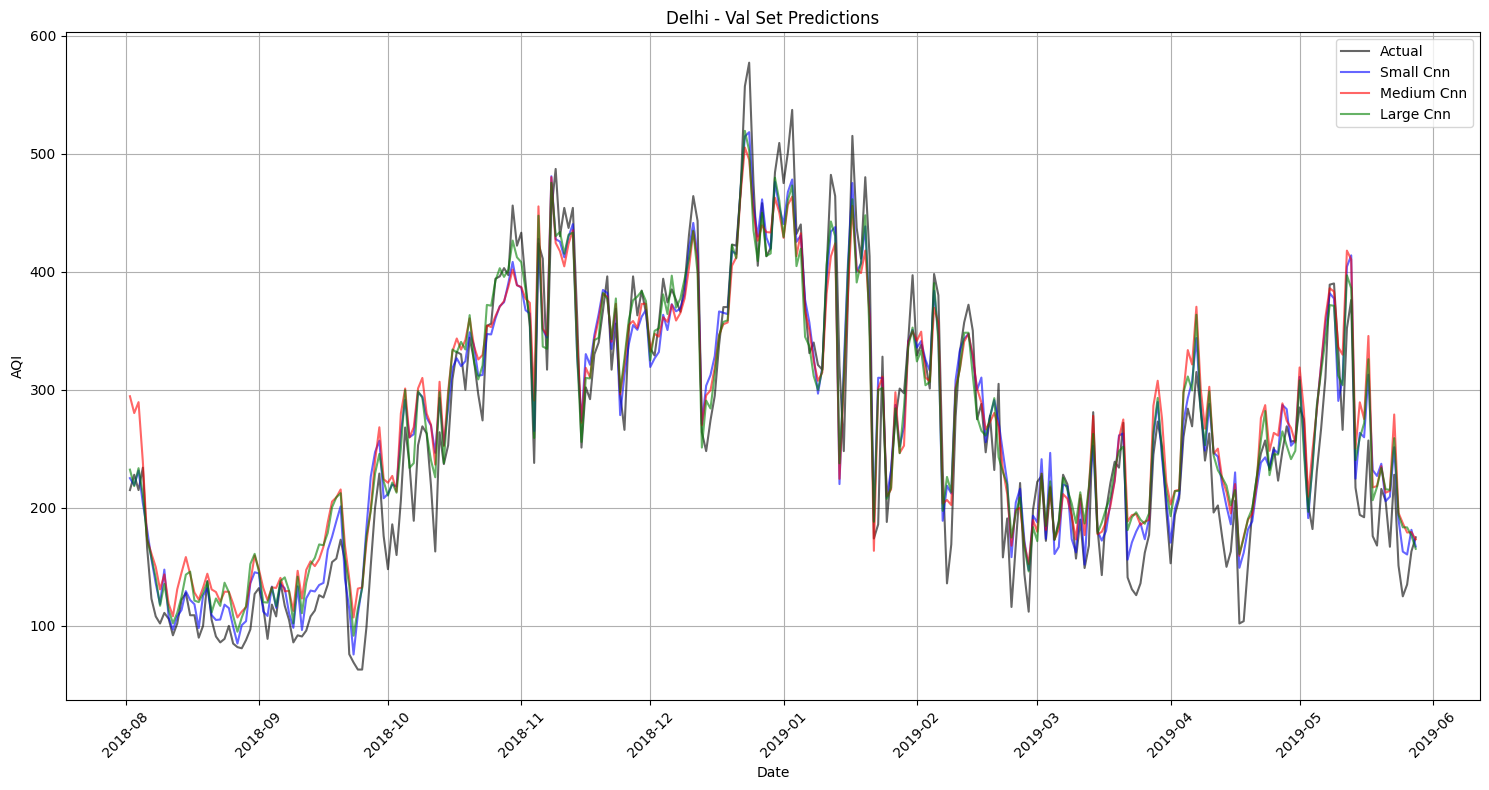

In [78]:
# Train all variants
results = {}
for model_name, config in model_configs.items():
    results[model_name] = train_model_variant(
        config['model_class'],
        model_name,
        city_data,
        'delhi',
        **config['params']
    )

save_cnn_visualizations('delhi', results, city_data)

In [64]:
city_data = load_city_data('bengaluru')

Loading data for bengaluru...
Loaded train set: 1241 samples
Loaded val set: 287 samples
Loaded test set: 382 samples



🔄 Training small_cnn for bengaluru...

🔄 Preprocessing data for bengaluru...
🔧 Initializing model...
Using model: SmallCNNRegressor
🏃 Starting training...
Epoch [10/200], Train Loss: 0.6854, Val Loss: 0.1708
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Epoch [20/200], Train Loss: 0.6384, Val Loss: 0.1426
Epoch [30/200], Train Loss: 0.5975, Val Loss: 0.1570
Epoch 00032: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.
Epoch [40/200], Train Loss: 0.5948, Val Loss: 0.1382
Epoch 00046: reducing learning rate of group 0 to 6.2500e-05.
Epoch [50/200], Train Loss: 0.5725, Val Loss: 0.1590
Epoch 00052: reducing learning rate of group 0 to 3.1250e-05.
⚠️ Early stopping at epoch 55
📊 Evaluating model...

📍 Evaluation Results for bengaluru (PyTorch CNN)

Validation Metrics:
RMSE: 18.11
MAE: 13.64
R²: 0.49

Test Metrics:
RMSE: 11.85
MAE: 8.53
R²: 0.63

🔄 Training medium_cnn for bengaluru...

🔄 Preprocessing data for be

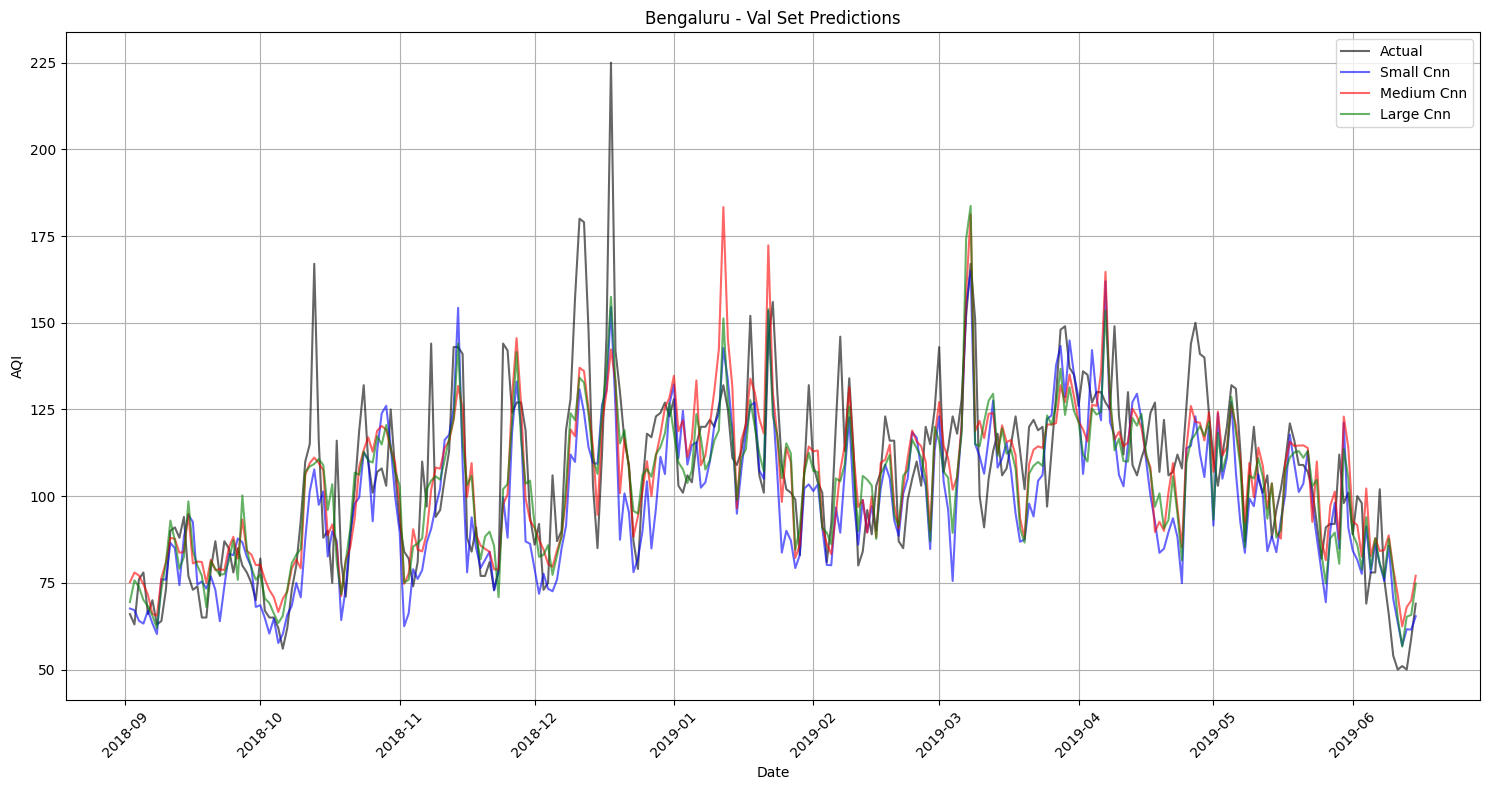

In [76]:
# Train all variants
results = {}
for model_name, config in model_configs.items():
    results[model_name] = train_model_variant(
        config['model_class'],
        model_name,
        city_data,
        'bengaluru',
        **config['params']
    )

save_cnn_visualizations('bengaluru', results, city_data)

In [79]:
city_data = load_city_data('chennai')

Loading data for chennai...
Loaded train set: 1224 samples
Loaded val set: 283 samples
Loaded test set: 377 samples



🔄 Training small_cnn for chennai...

🔄 Preprocessing data for chennai...
🔧 Initializing model...
Using model: SmallCNNRegressor
🏃 Starting training...
Epoch [10/200], Train Loss: 0.6080, Val Loss: 0.4967
Epoch [20/200], Train Loss: 0.5980, Val Loss: 0.2628
Epoch 00028: reducing learning rate of group 0 to 5.0000e-04.
Epoch [30/200], Train Loss: 0.4755, Val Loss: 0.2317
Epoch 00035: reducing learning rate of group 0 to 2.5000e-04.
Epoch [40/200], Train Loss: 0.4247, Val Loss: 0.2227
Epoch 00041: reducing learning rate of group 0 to 1.2500e-04.
⚠️ Early stopping at epoch 44
📊 Evaluating model...

📍 Evaluation Results for chennai (PyTorch CNN)

Validation Metrics:
RMSE: 26.08
MAE: 19.68
R²: 0.63

Test Metrics:
RMSE: 22.58
MAE: 17.10
R²: 0.60

🔄 Training medium_cnn for chennai...

🔄 Preprocessing data for chennai...
🔧 Initializing model...
Using model: MediumCNNRegressor
🏃 Starting training...
Epoch [10/200], Train Loss: 0.6061, Val Loss: 0.2551
Epoch [20/200], Train Loss: 0.5336, Val Los

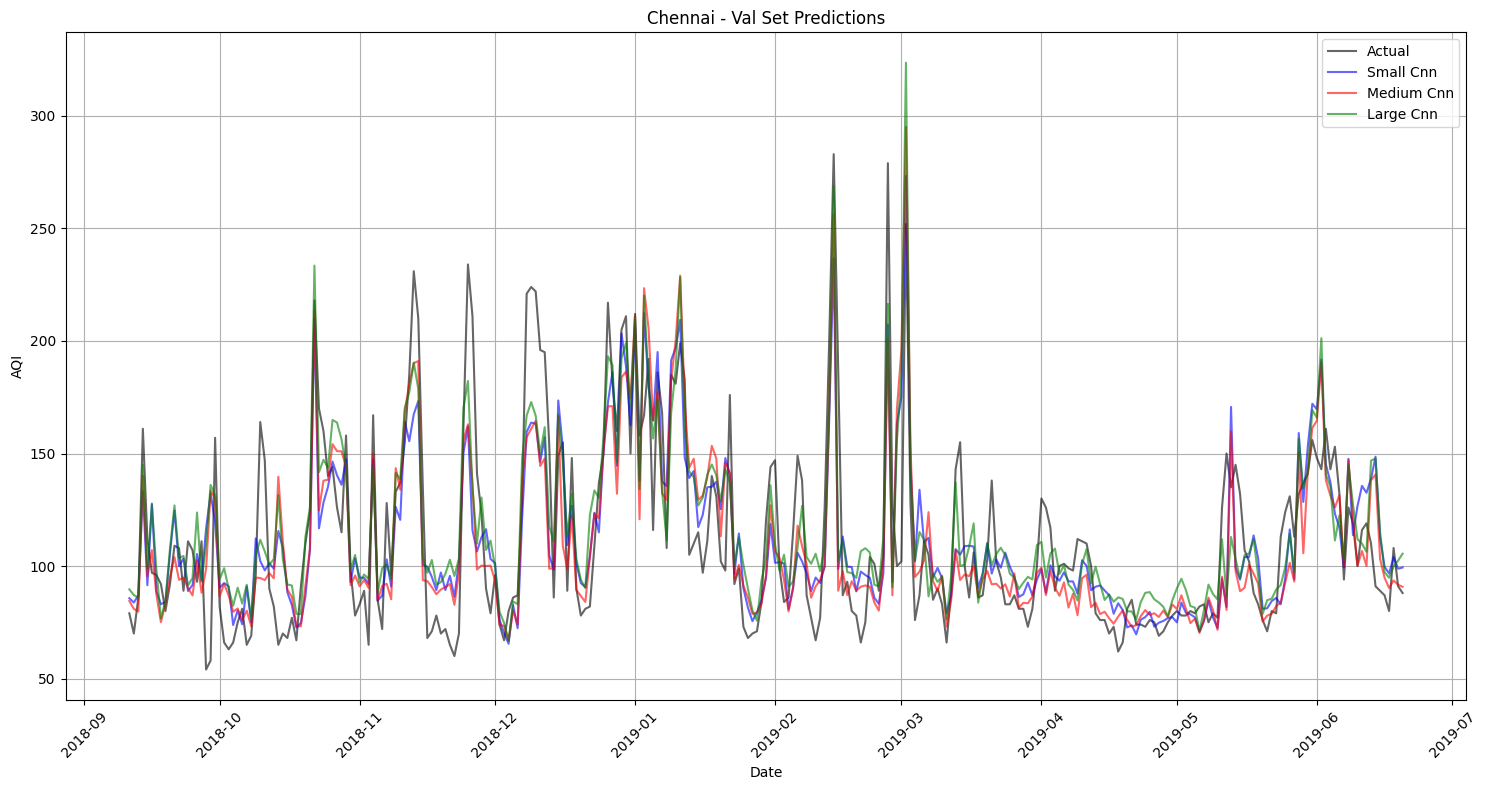

In [80]:
# Train all variants
results = {}
for model_name, config in model_configs.items():
    results[model_name] = train_model_variant(
        config['model_class'],
        model_name,
        city_data,
        'chennai',
        **config['params']
    )

save_cnn_visualizations('chennai', results, city_data)

In [81]:
city_data = load_city_data('hyderabad')


Loading data for hyderabad...
Loaded train set: 1222 samples
Loaded val set: 282 samples
Loaded test set: 376 samples



🔄 Training small_cnn for hyderabad...

🔄 Preprocessing data for hyderabad...
🔧 Initializing model...
Using model: SmallCNNRegressor
🏃 Starting training...
Epoch [10/200], Train Loss: 0.4420, Val Loss: 0.0939
Epoch [20/200], Train Loss: 0.4024, Val Loss: 0.0819
Epoch [30/200], Train Loss: 0.3363, Val Loss: 0.0798
Epoch 00034: reducing learning rate of group 0 to 5.0000e-04.
Epoch [40/200], Train Loss: 0.2835, Val Loss: 0.0847
Epoch 00045: reducing learning rate of group 0 to 2.5000e-04.
Epoch [50/200], Train Loss: 0.3048, Val Loss: 0.0652
Epoch [60/200], Train Loss: 0.3023, Val Loss: 0.0626
Epoch 00065: reducing learning rate of group 0 to 1.2500e-04.
Epoch [70/200], Train Loss: 0.2535, Val Loss: 0.0559
Epoch 00071: reducing learning rate of group 0 to 6.2500e-05.
⚠️ Early stopping at epoch 74
📊 Evaluating model...

📍 Evaluation Results for hyderabad (PyTorch CNN)

Validation Metrics:
RMSE: 14.19
MAE: 10.80
R²: 0.71

Test Metrics:
RMSE: 16.50
MAE: 12.94
R²: 0.78

🔄 Training medium_cnn 

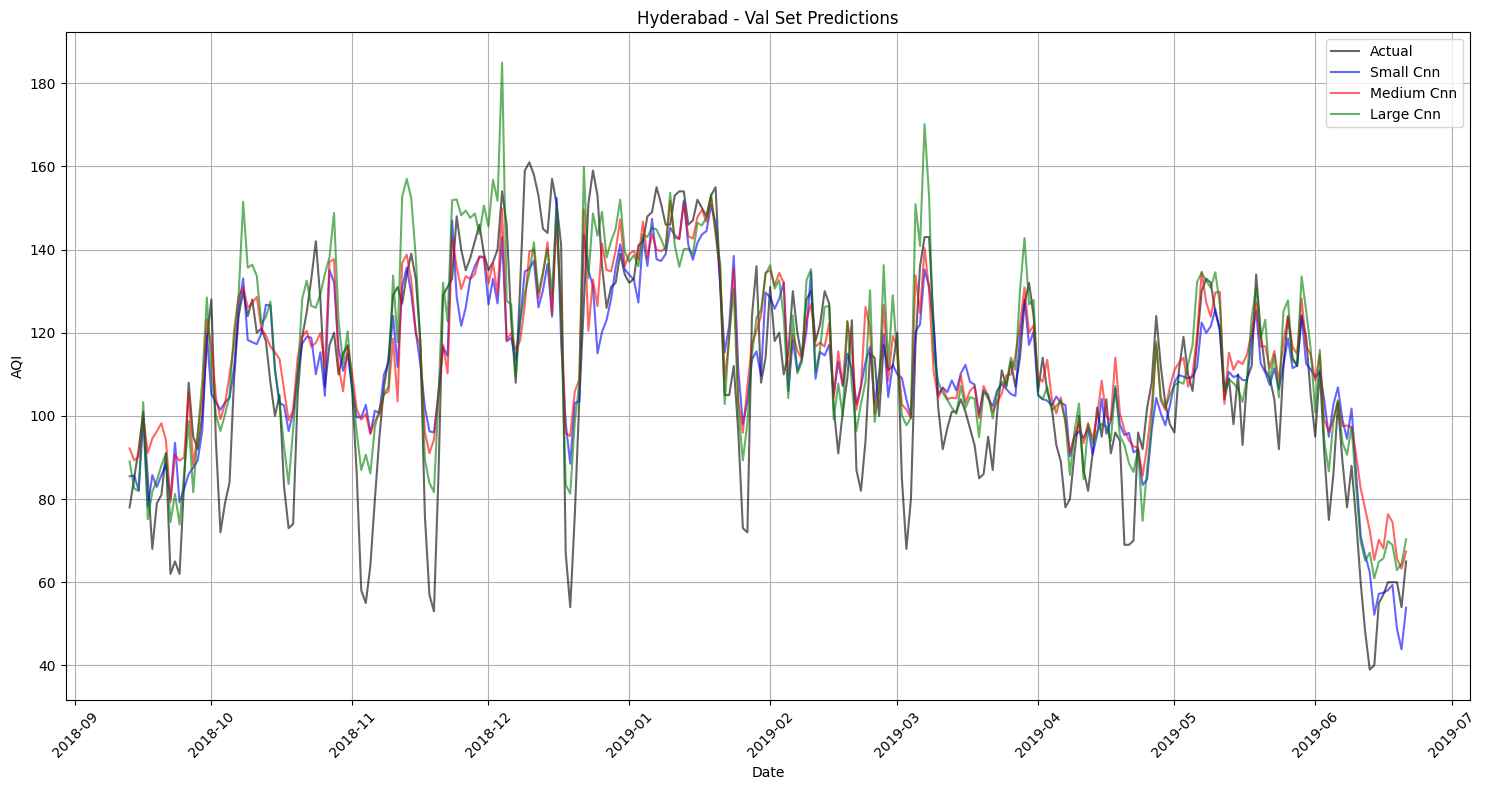

In [82]:
results = {}
for model_name, config in model_configs.items():
    results[model_name] = train_model_variant(
        config['model_class'],
        model_name,
        city_data,
        'hyderabad',
        **config['params']
    )

save_cnn_visualizations('hyderabad', results, city_data)